In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO: automate with nice data configs of selected variables etc.
# TODO: logging functions

from pathlib import Path
import xarray as xa
import geopandas as gpd
from datetime import datetime
import dask
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client, LocalCluster
import dask
import xgboost as xgb
from dask_ml.model_selection import HyperbandSearchCV
from dask_ml.model_selection import RandomizedSearchCV as dask_RandomizedSearchCV

import joblib

from sklearn.metrics import mean_squared_error
import sklearn.metrics as sklmetrics
import dask_ml.model_selection as dcv
from scipy.stats import expon
from sklearn import svm, datasets

import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV


from coralshift.dataloading import config, get_data
from coralshift import functions_creche
from coralshift.processing import spatial_data
from coralshift.machine_learning import baselines
from coralshift.plotting import spatial_plots
from coralshift.utils import utils


data_fp = config.data_folder

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/lustre_scratch/conda-envs/coralshift/share/proj failed


In [3]:
high_res_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc")
high_res_ds.latitude.values[:5]

array([-32.  , -31.99, -31.98, -31.97, -31.96])

In [14]:
resolution_lat, resolution_lon = 0.01, 0.01

# ((X_train, y_train), (X_test, y_test)), dfs_list = get_data.get_data("rf", resolution_lat, resolution_lon)
# common_df = get_data.get_data("transformer", resolution_lat, resolution_lon)

In [3]:
def split_dataset_and_save(ds_fp, divisor, output_dir_name: str=None, select_vars: list[str]=None):
    
    ds = xa.open_dataset(ds_fp)
    
    if select_vars:
        ds = ds[select_vars]
            
    subsets_dict = split_dataset_by_indices(ds, divisor)
    
    # Create a subdirectory to save the split datasets
    if output_dir_name:
        output_dir = Path(ds_fp).parent / f"{output_dir_name}_{divisor**2}_split_datasets"
    else:
        output_dir = Path(ds_fp).parent / f"{divisor**2}_split_datasets"
    output_dir.mkdir(parents=True, exist_ok=True)

    
    for coord_info, subset in tqdm(subsets_dict.items(), desc="saving dataset subsets..."):
        stem_stem = str(Path(ds_fp).stem).split("lats")[0]
        # Construct the filename based on bounds
        filename = f"{stem_stem}_{coord_info}.nc"
        save_fp = output_dir / filename
        subset.to_netcdf(save_fp)
    return subsets_dict
    

def split_dataset_by_indices(dataset, divisor) -> dict:
    subsets_dict = {}
    num_lats = len(dataset.latitude.values) // divisor
    num_lons = len(dataset.longitude.values) // divisor
    for i in range(divisor):
        for j in range(divisor):
            start_lat_ind = i * num_lats
            start_lon_ind = j * num_lons
            
            subset = dataset.isel(latitude=slice(start_lat_ind, start_lat_ind + num_lats),
                                  longitude=slice(start_lon_ind, start_lon_ind + num_lons))
            
            lat_lims = spatial_data.min_max_of_coords(subset, "latitude")
            lon_lims = spatial_data.min_max_of_coords(subset, "longitude")
            
            coord_info = functions_creche.tuples_to_string(lat_lims, lon_lims)
            subsets_dict[coord_info] = subset
    
    return subsets_dict


def ds_to_ml_ready(ds, 
    gt:str="unep_coral_presence", exclude_list: list[str]=["latitude", "longitude", "latitude_grid", "longitude_grid", "crs", "depth", "spatial_ref"], 
    train_val_test_frac=[1,0,0], inf_type: str="classification", threshold=0.5, depth_mask_lims = [-50, 0], client=None, remove_rows:bool=False):
    
    df = ds.compute().to_dataframe()
    # TODO: implement checking for empty dfs

    predictors = [pred for pred in df.columns if pred != gt and pred not in exclude_list]
    depth_condition = (df["elevation"] < max(depth_mask_lims)) & (df["elevation"] > min(depth_mask_lims))
    
    if remove_rows:
        df = df[depth_condition]
    else:
        df["within_depth"] = 0
        df.loc[depth_condition, "within_depth"] = 1
        
    if len(df) > 0:
        scaler = MinMaxScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index = df.index)
    
    df["nan_onehot"] = df.isna().any(axis=1).astype(int)
    df = df.fillna(0)
    
#     X = df[predictors].to_numpy()
#     y = df[gt].to_numpy()
    
    X = df[predictors]
    y = df[gt]
    
    return X, y

def cont_to_class(array, threshold=0.5):
    array[array >= threshold] = 1
    array[array < threshold] = 0

    return array.astype(int)


def customize_plot_colors(fig, ax, background_color="#212121", text_color="white"):
    # Set figure background color
    fig.patch.set_facecolor(background_color)

    # Set axis background color (if needed)
    ax.set_facecolor(background_color)

    # Set text color for all elements in the plot
    for text in fig.texts:
        text.set_color(text_color)
    for text in ax.texts:
        text.set_color(text_color)
    for text in ax.xaxis.get_ticklabels():
        text.set_color(text_color)
    for text in ax.yaxis.get_ticklabels():
        text.set_color(text_color)
    ax.title.set_color(text_color)
    ax.xaxis.label.set_color(text_color)
    ax.yaxis.label.set_color(text_color)

    # Set legend text color
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_color(text_color)

    return fig, ax

In [4]:
num_files = -1
train_nc_fps = list(Path("data/64_split_datasets").glob("temp_rf*.nc"))[:num_files]
# test_nc_fps = list(Path("data/64_split_datasets").glob("temp_rf*.nc"))[num_files:num_files + num_files]


train_Xs, train_ys = [], []
for i, fp in tqdm(enumerate(train_nc_fps), total=len(train_nc_fps)):
    ds = xa.open_dataset(fp)
    X, y = ds_to_ml_ready(ds, remove_rows=True)
#     print(sum(y))
    train_Xs.append(X)
    train_ys.append(y)

X_df = pd.concat(train_Xs, axis=0)
y_df = pd.concat(train_ys, axis=0)

# test_Xs, test_ys = [], []
# for i, fp in enumerate(test_nc_fps):
#     ds = xa.open_dataset(fp)
#     X, y = ds_to_ml_ready(ds, remove_rows=True)
#     test_Xs.append(X)
#     test_ys.append(y)

 32%|███▏      | 20/63 [00:24<00:36,  1.18it/s]/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
 62%|██████▏   | 39/63 [00:40<00:22,  1.05it/s]/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
 67%|██████▋   | 42/63 [00:43<00:19,  1.06it/s]/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/sklearn/preproce

In [6]:
X = X_df.to_numpy()
y = y_df.to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (714558, 202)
y shape: (714558,)


In [ ]:
# train_Xs = pd.concat(train_Xs, axis=0)
# train_ys = pd.concat(train_ys, axis=0)

# test_Xs = pd.concat(test_Xs, axis=0)
# test_ys = pd.concat(test_ys, axis=0)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# client.close()

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

model_type="classification"
n_samples = 10000
threshold = 0.25

y_train = cont_to_class(y_train, 0.25)

class_counts = np.bincount(y_train)
total_samples = len(y_train)

class_weight = {
    0: total_samples / (2 * class_counts[0]),
    1: 5*total_samples / (2 * class_counts[1])
}

# Create the XGBoost DMatrices
dX_train = dask.array.from_array(X_train)
dy_train = dask.array.from_array(y_train).rechunk(dX_train.chunksize[0])

dX_test = dask.array.from_array(X_test)
dy_test = dask.array.from_array(y_test).rechunk(dX_test.chunksize[0])


if model_type == "classification":
    y_train = cont_to_class(y_train, threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)
    
    model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))
    
elif model_type == "regression":
    model = xgb.XGBRegressor(
        n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)
    )


# dtrain = xgb.dask.DaskDMatrix(client, dX_train, dy_train)
# dtest = xgb.dask.DaskDMatrix(client, dX_test,  dy_test)

param_space = {
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'class_weight': ['balanced', class_weight],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 5, 10, 20],
#     'max_samples': [None, 0.5, 0.7, 0.9],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'oob_score': [True, False],
    'random_state': [42],  # Add different seed values if desired
#     'warm_start': [True, False]
    # Add more parameters and ranges as needed
}

search = RandomizedSearchCV(model, param_space, cv=3, n_iter=100, verbose=2, n_jobs=-1)

# already saved to pickle
with joblib.parallel_backend('dask'):
    search.fit(X_train[:n_samples], y_train[:n_samples])
    
with open(f"xgb_cl_best_rerun.pickle", "wb") as handle:
    pickle.dump(search.best_params_, handle, protocol=-1)

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46279 instead
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=5, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=10, min_weight_fraction_leaf=0.2, n_estimators=100, oob_score=False, random_state=42; total time=  17.2s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight={0: 0.5659906217078947, 1: 21.442085521380346}, criterion=entropy, max_depth=100, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.1, n_estimators=50, oob_score=False, random_state=42; total time=  20.1s
[CV] END bootstrap=False, ccp_alpha=0.2, class_weight=balanced, criterion=gini, max_depth=50, max_features=log2, max_leaf_nodes=5, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=5, min_weight_fraction_leaf=0.2, n_estimators=50, oob_score=False, random_state=42; total time=  20

In [10]:
# throwing xgb has no attribute dask errors
# # make predictions
# y_test_pred = xgb.dask.predict(client, output, dtest).compute()
# y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test

# # plt.scatter(y_train,y_train_pred, alpha=0.1) #overfit
# # plt.scatter(y_test,y_test_pred, alpha=0.1)
print("DONE")


DONE


In [ ]:
# pkl_fp = "xgb_cl_best.pickle"
# pkl = True
# n_samples = 10000

# cluster = LocalCluster(n_workers=4)
# client = Client(cluster)


# if pkl:
#     with open(pkl_fp, 'rb') as handle:
#         best_params_ = pickle.load(handle)
#     model = xgb.XGBClassifier(**best_params_)
# else:
#     model = xgb.XGBClassifier(**search.best_params_)

# with joblib.parallel_backend('dask'):
#     model.fit(X_train[:n_samples], y_train[:n_samples])

# # y_test_pred = model.predict_proba(X_test) # 2xN
# y_test_pred = model.predict(X_test[:10])

In [11]:
model = xgb.XGBClassifier(**search.best_params_)

with joblib.parallel_backend('dask'):
    model.fit(X_train[:n_samples], y_train[:n_samples])
    # model.fit(X_train, y_train)

# y_test_pred = model.predict_proba(X_test) # 2xN
y_test_pred = model.predict(X_test[n_samples:])

balanced_accuracy_score 0.7828114493962354
accuracy_score 0.9257934952978056
f1_score 0.6519184691633572


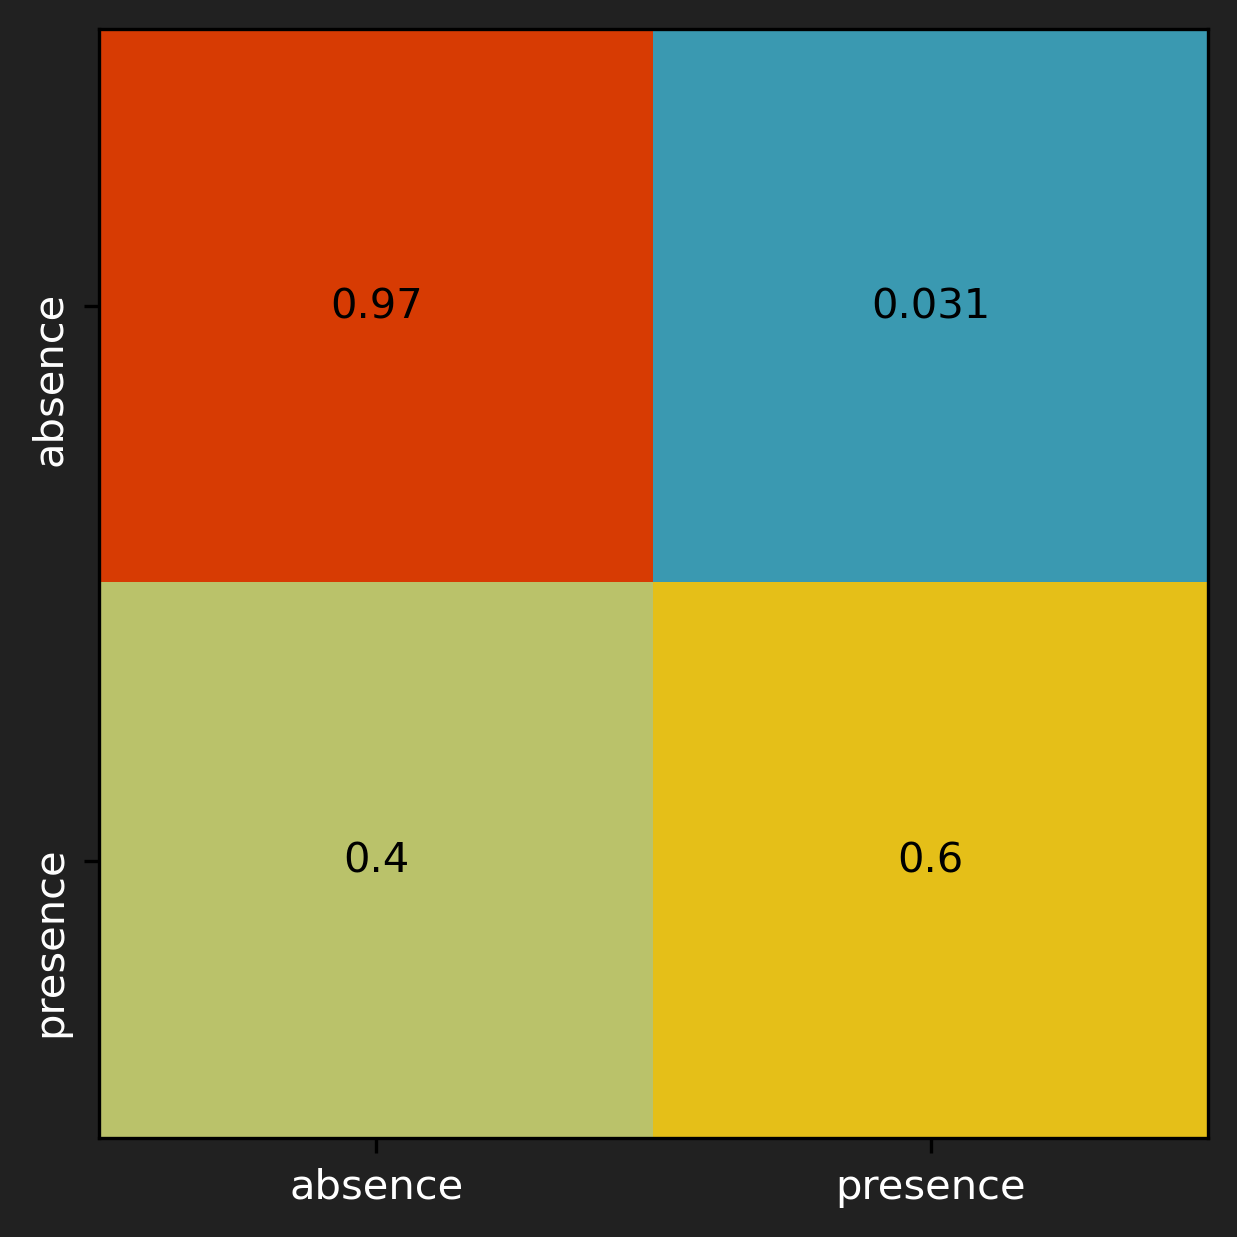

In [13]:
# formatting confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar()


cm = confusion_matrix(y_test, cont_to_class(y_test_pred, 0.5), labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                              # , cmap=cmap
                             )

customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap, text_kw={"c":"k"}, colorbar=False)

ax.set_xlabel('')
ax.set_ylabel('')

plt.yticks(rotation=90)

balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_test, y_test_pred)
accuracy_score = sklmetrics.accuracy_score(y_test, y_test_pred)
f1_score = sklmetrics.f1_score(y_test, y_test_pred)

print("balanced_accuracy_score", balanced_accuracy_score)
print("accuracy_score", accuracy_score)
print("f1_score", f1_score)


In [14]:
test_ds = xa.open_dataset(train_nc_fps[-2])


In [12]:
# X_df, y_df = ds_to_ml_ready(test_ds)

# X_df = pd.concat(train_Xs, axis=0)
# y_df = pd.concat(train_ys, axis=0)

predictions = model.predict(X_df.to_numpy())

y_cont = cont_to_class(y_df.to_numpy(), 0.25)

In [13]:
# reformed = pd.concat([X_df, pd.Series(predictions)], axis=1

# Convert the multi-index DataFrame X to a NumPy array
X_np = X_df.to_numpy()

# Check shapes to ensure compatibility for concatenation
if len(X_np) == len(predictions):
    # Concatenate X (as a NumPy array) with y along the columns (axis=1)
    concatenated_data = np.concatenate((X_np, predictions[:, np.newaxis]), axis=1)
    # Creating a new DataFrame if needed
    concatenated_df = pd.DataFrame(concatenated_data, index=X_df.index, columns=list(X_df.columns) + ['predictions'])
else:
    print("Lengths of X and y do not match")

In [14]:
out = concatenated_df.to_xarray()

NameError: name 'test_ds' is not defined

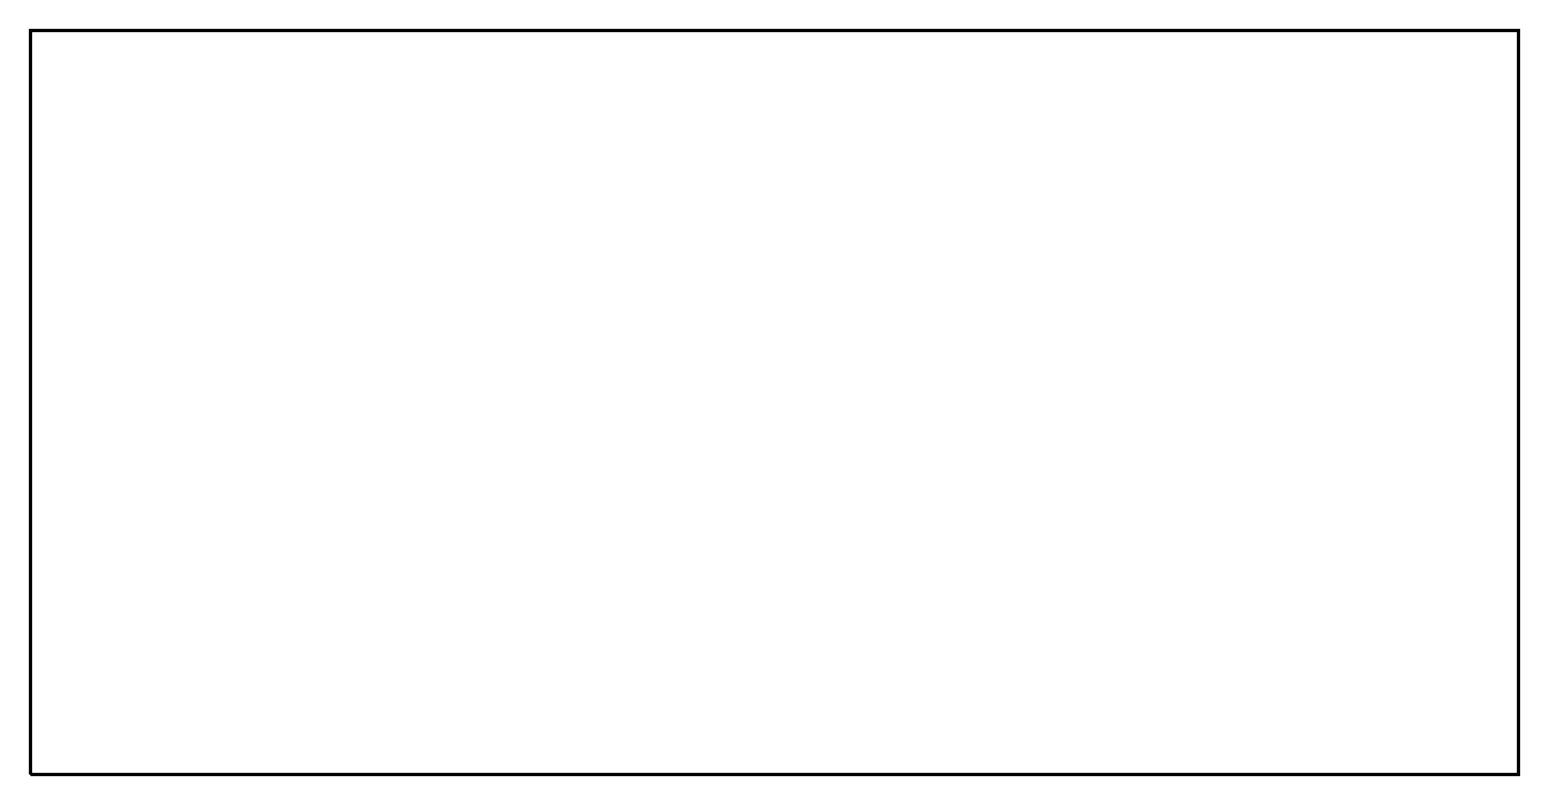

In [15]:
f,ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
spatial_plots.plot_spatial(test_ds["unep_coral_presence"], fax=(f,ax), title="", orient_colorbar="horizontal", cbar=False)


customize_plot_colors(f,ax)
plt.title("")

# ax.legend()
# legend = plt.legend()

# # Set legend text color to white
# for text in legend.get_texts():
#     text.set_color('white')
    
# spatial_plots.plot_spatial(out["predictions"])


Text(0.5, 1.0, '')

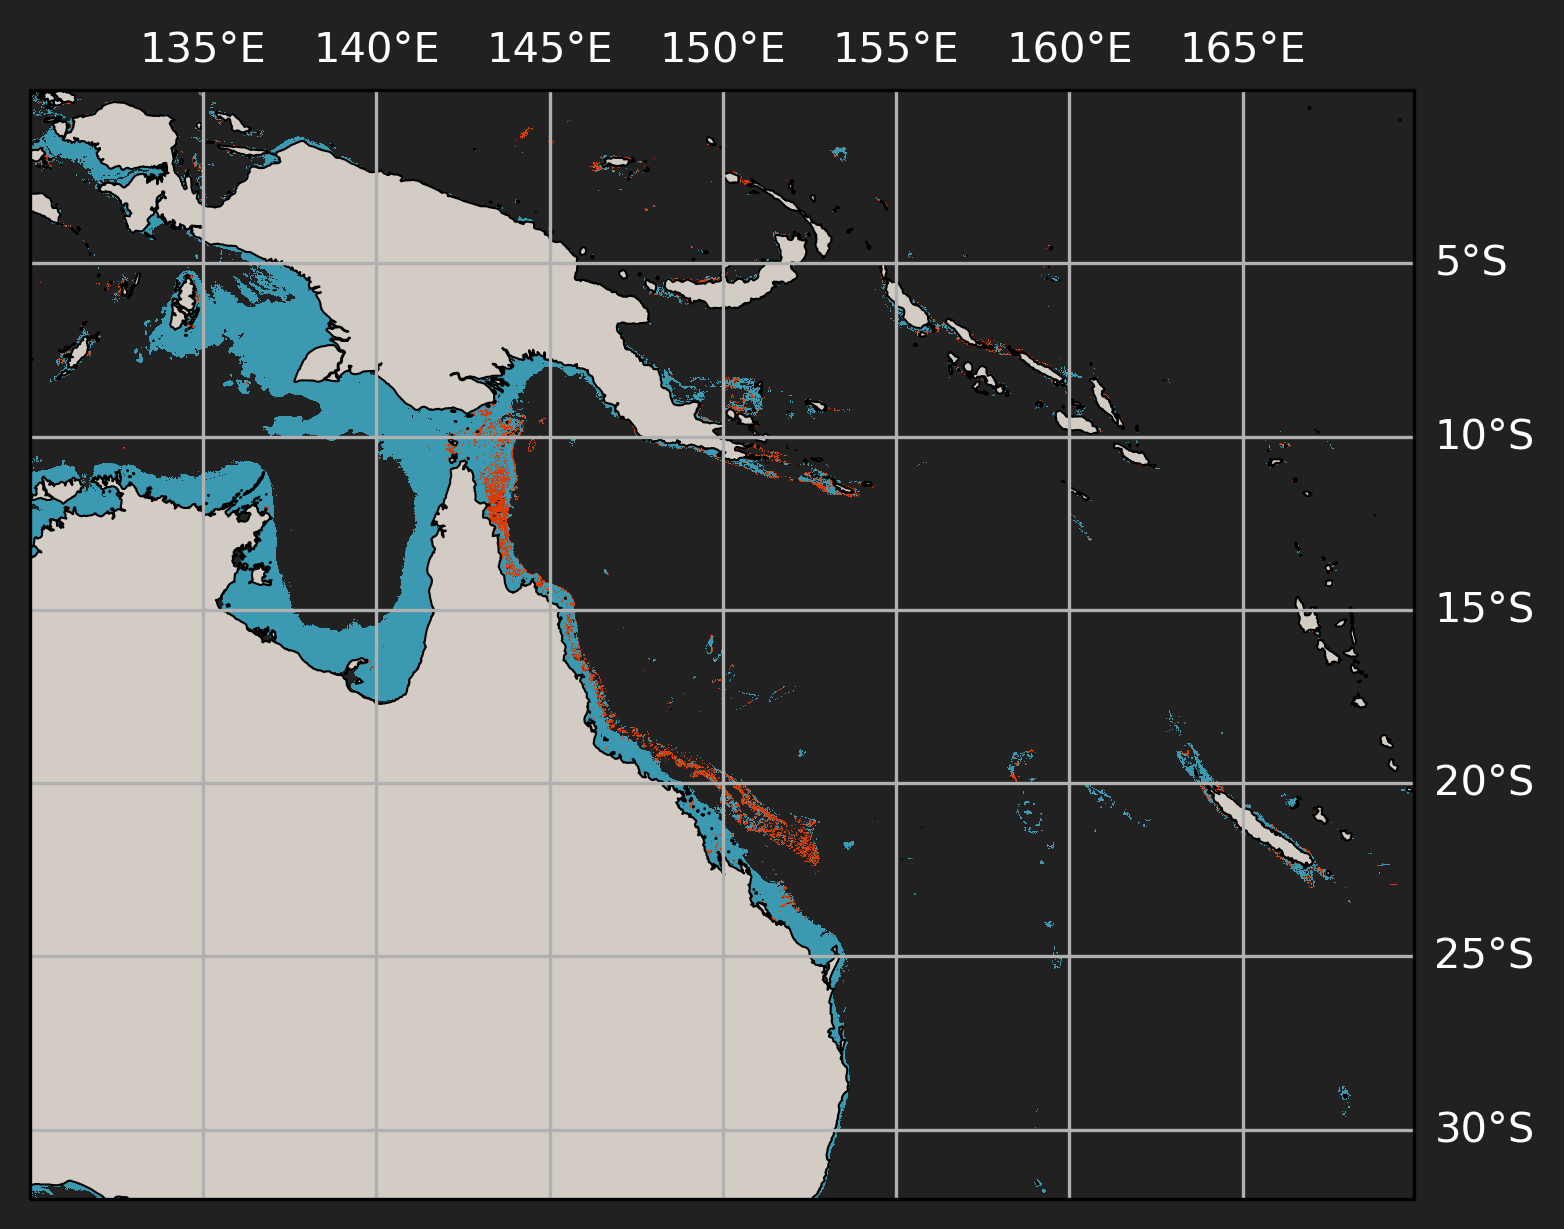

In [16]:
f,ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
spatial_plots.plot_spatial(out["predictions"], fax=(f,ax), title="", orient_colorbar="horizontal", cbar=False)

customize_plot_colors(f,ax)
plt.title("")

In [38]:
sklmetrics.f1_score(y_cont, predictions)

0.6506744459556238

NameError: name 'confusion_matrix' is not defined

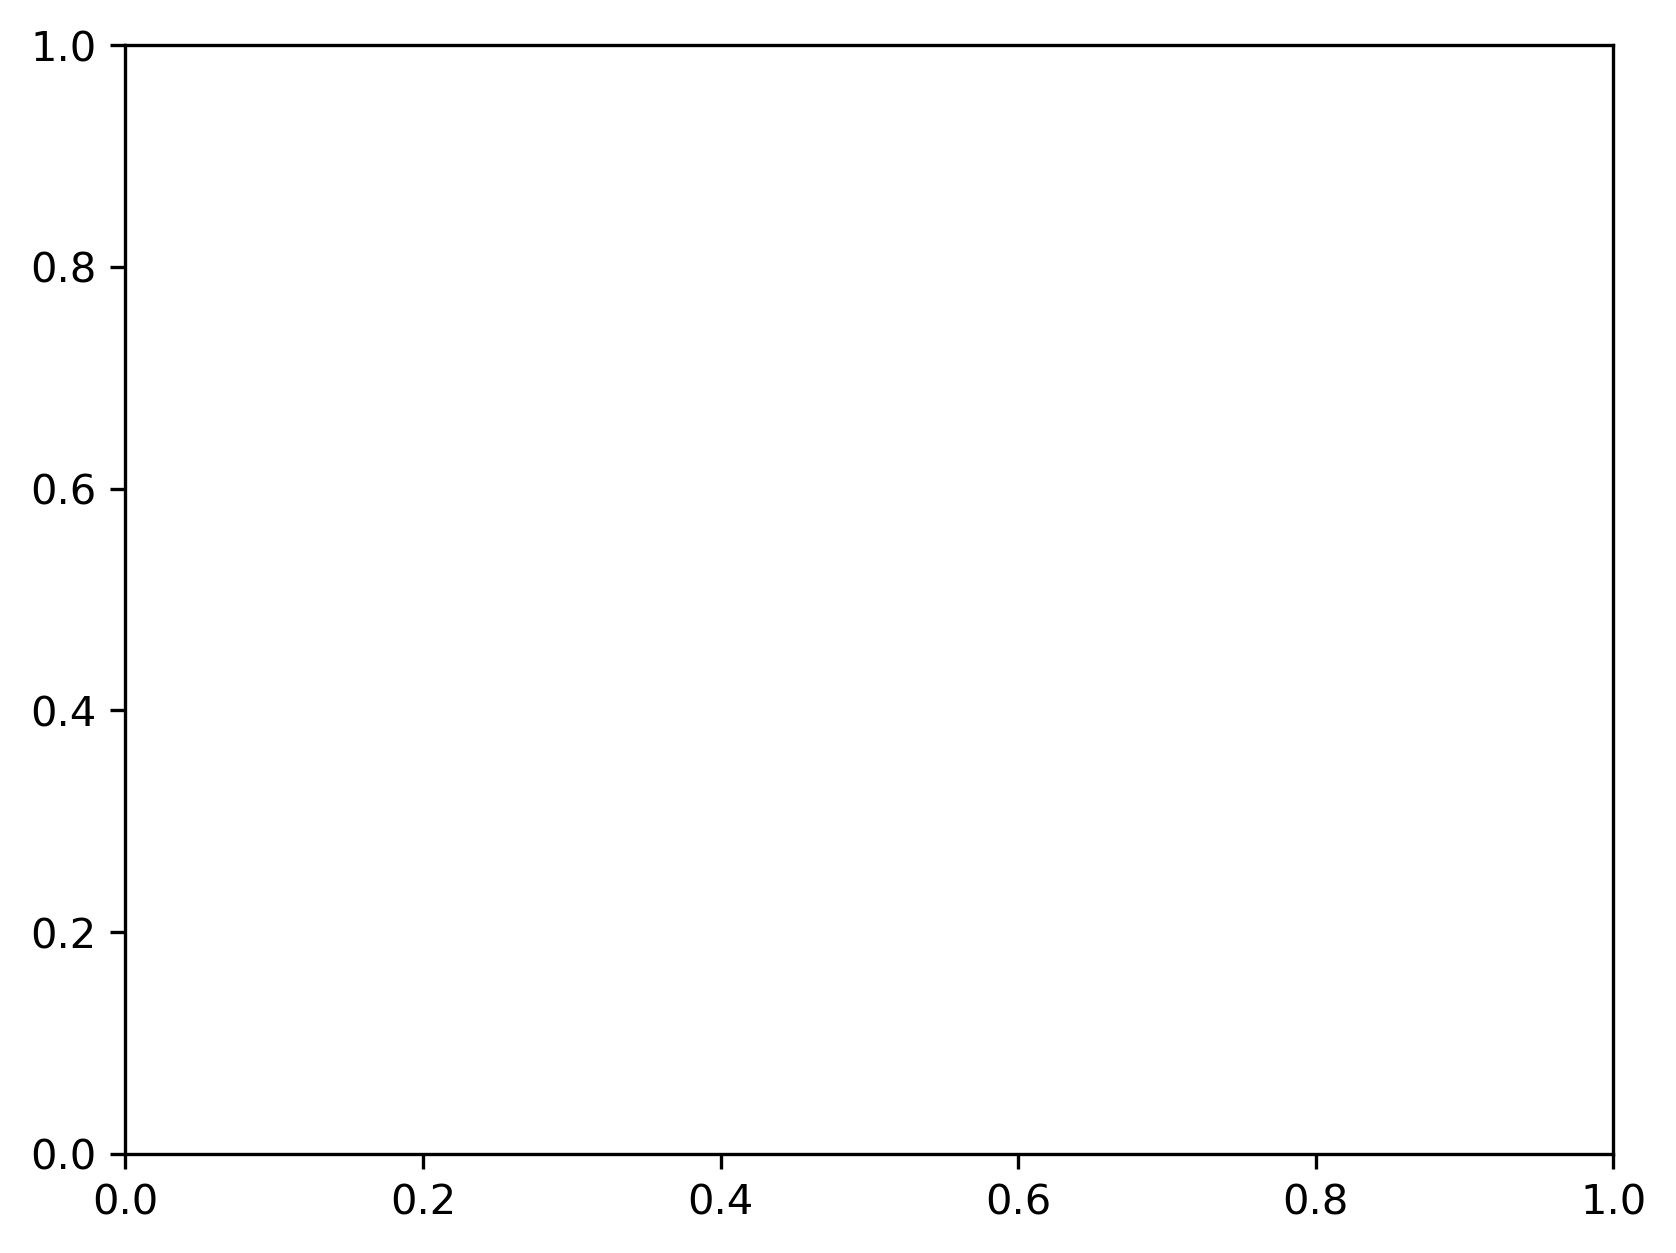

In [10]:
fig, ax = plt.subplots(dpi=300)

cmap = spatial_plots.get_cbar("lim")


cm = confusion_matrix(predictions, y_cont, labels=[0, 1], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"],
                              # , cmap=cmap
                             )

customize_plot_colors(fig,ax)
disp.plot(ax=ax, cmap=cmap)


balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_cont, predictions)
accuracy_score = sklmetrics.accuracy_score(y_cont, predictions)
f1_score = sklmetrics.f1_score(y_cont, predictions)

print("balanced_accuracy_score", balanced_accuracy_score)
print("accuracy_score", accuracy_score)
print("f1_score", f1_score)

In [9]:
resolutions = [
    # 1, 0.5, 0.1
    # 0.25, 0.05
    0.01
]

def get_min_max_coords(ds, coord):
    min_coord = float(min(ds[coord]).values)
    max_coord = float(max(ds[coord]).values)
    return min_coord, max_coord


def process_df_for_ml(
    df: pd.DataFrame, ignore_vars: list[str], drop_all_nans: bool = True
) -> pd.DataFrame:
    # drop ignored vars
    df = df.drop(columns=list(set(ignore_vars).intersection(df.columns)))

    if drop_all_nans:
        # remove rows which are all nans
        df = utils.drop_nan_rows(df)
    # onehot encoode any remaining nans
    df["onehotnan"] = df.isnull().any(axis=1).astype(int)
    # fill nans with 0
    df = df.fillna(0)

    # flatten dataset for row indexing and model training
    return df



def xa_dss_to_df(
    xa_dss: list[xa.Dataset],
    bath_mask: bool = True,
    res: float = 1,
    ignore_vars: list = ["spatial_ref", "band", "depth"],
    drop_all_nans: bool = True,
):
    dfs = []
    
    limits_dict = {
        1: [-2000,0],
        0.5: [-1000,0],
        0.25: [-500,0],
        0.1: [-80,0],
        0.05: [-60,0],
        0.01: [-20,0],
    }
    for xa_ds in xa_dss:
        
        
        if bath_mask:
            print(limits_dict[res])
            # set all values outside of the shallow water region to nan for future omission
            shallow_mask = spatial_data.generate_var_mask(xa_ds,mask_var="elevation",
                                                          limits=limits_dict[res]
                                                         )
            xa_ds = xa_ds.where(shallow_mask, np.nan)

        # compute out dasked chunks, send type to float32, stack into df, drop any datetime columns
        df = (
            xa_ds.stack(points=("latitude", "longitude"))
            .compute()
            .astype("float32")
            .to_dataframe()
        )
        # drop temporal columns
        df = df.drop(columns=list(df.select_dtypes(include="datetime64").columns))
        df = process_df_for_ml(df, ignore_vars=ignore_vars, drop_all_nans=drop_all_nans)

        dfs.append(df)
    return dfs



def generate_split(ds, res):
    
    # flatten datasets to pandas dataframes and process
    flattened_data_dfs = xa_dss_to_df([ds], bath_mask=True, res=res)
    # generate training and testing coordinates

    # normalise dataframe via min/max scaling
    normalised_dfs = [
        (flattened_data - flattened_data.min())
        / (flattened_data.max() - flattened_data.min())
        for flattened_data in flattened_data_dfs
    ]

    y = normalised_dfs[0]["unep_coral_presence"].to_numpy()
    X = normalised_dfs[0].loc[:, normalised_dfs[0].columns != 'unep_coral_presence'].to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


def train_model(model_type: str, X_train, y_train, cv=3, n_iter=50, n_samples=-1):
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)

    if model_type == "classification":
        y_train = cont_to_class(y_train, threshold=threshold)
        y_test = cont_to_class(y_test, threshold=threshold)

        model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))
    
    elif model_type == "regression":
        model = xgb.XGBRegressor(
            n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)
        )

    class_counts = np.bincount(y_train)
    total_samples = len(y_train)

    class_weight = {
        0: total_samples / (2 * class_counts[0]),
        1: 5*total_samples / (2 * class_counts[1])
    }

    param_space = {
        'bootstrap': [True, False],
        'ccp_alpha': [0.0, 0.1, 0.2],
        'class_weight': ['balanced', class_weight],
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 7, 10, 50, 100],
        'max_features': ['sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 20],
    #     'max_samples': [None, 0.5, 0.7, 0.9],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'oob_score': [True, False],
        'random_state': [42],  # Add different seed values if desired
    #     'warm_start': [True, False]
        # Add more parameters and ranges as needed
    }

    model = xgb.XGBClassifier()
    search = RandomizedSearchCV(model, param_space, cv=cv, n_iter=n_iter, verbose=2, n_jobs=-1)
    
    with joblib.parallel_backend('dask'):
        search.fit(X_train[:n_samples], y_train[:n_samples])
    client.close()
    
    return search.best_params_, search



def models_at_resolutions(high_res_ds, resolutions:list, model_type, cv, n_iter, n_samples, threshold=0.25):
    
    models = []
    best_param_dicts = {}
    balanced_accuracy_scores = []
    accuracy_scores = []
    f1_scores = []
    
    for res in tqdm(resolutions, desc="iterating over resolutions..."):
        lat_range = get_min_max_coords(high_res_ds, "latitude")
        lon_range = get_min_max_coords(high_res_ds, "longitude")
        
        if res == 0.01:
            print(f"not bypassing resampling since already at {res}")
            # ds_res = high_res_ds
            ds_res = functions_creche.resample_xa_d(high_res_ds, lat_range, lon_range, res, res)
        else:
            ds_res = functions_creche.resample_xa_d(high_res_ds, lat_range, lon_range, res, res)
        
        X_train, X_test, y_train, y_test = generate_split(ds_res, res)
        
        
        if model_type == "classifier":
            y_train = cont_to_class(y_train[:n_samples], threshold=threshold)
            y_test = cont_to_class(y_test[:n_samples], threshold=threshold)
            
            if n_samples > len(X_train):
                print(f"reassigned n_samples to len(X_train):", len(X_train))
                n_samples = len(X_train[:n_samples])
            
            best_params, search = train_model("classifier", X_train[:n_samples], y_train[:n_samples], cv, n_iter, n_samples)
            best_param_dicts[res] = best_params
            print(best_params)
            
            model = xgb.XGBClassifier(**best_params)
            model.fit(X_train[:n_samples], y_train[:n_samples])
            models.append(model)
                
            y_test_pred = cont_to_class(model.predict(X_test[:n_samples]), 0.5)
            balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_test[:n_samples], y_test_pred[:n_samples])
            accuracy_score = sklmetrics.accuracy_score(cont_to_class(y_test[:n_samples], 0.25), y_test_pred[:n_samples])
            f1_score = sklmetrics.f1_score(cont_to_class(y_test[:n_samples], 0.25), y_test_pred[:n_samples])
            
            with open(f"xgb_cl_standard_{res:.03f}.pickle", "wb") as handle:
                pickle.dump(best_params, handle, protocol=-1)
    
            balanced_accuracy_scores.append(balanced_accuracy_score)
            accuracy_scores.append(accuracy_score)
            f1_scores.append(f1_score)
            print(f"resolution: {res}°")
            print(f"balanced accuracy_score: {balanced_accuracy_score}")
            print(f"accuracy_score: {accuracy_score}")
            print(f"f1_score: {f1_score}")           
        
    return best_param_dicts, models, accuracy_scores, f1_scores, balanced_accuracy_scores

# high_res_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc")
best_param_dicts, models, accuracy_scores, f1_scores, balanced_accuracy_scores = models_at_resolutions(high_res_ds, resolutions, model_type="classifier", cv=5, n_iter=50, n_samples=10000)

iterating over resolutions...:   0%|          | 0/1 [00:00<?, ?it/s]

not bypassing resampling since already at 0.01
[-20, 0]


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33865 instead
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, ccp_alpha=0.2, class_weight=balanced, criterion=gini, max_depth=3, max_features=log2, max_leaf_nodes=5, min_impurity_decrease=0.2, min_samples_leaf=1, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=50, oob_score=False, random_state=42; total time=   2.6s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=10, min_impurity_decrease=0.1, min_samples_leaf=4, min_samples_split=5, min_weight_fraction_leaf=0.1, n_estimators=200, oob_score=True, random_state=42; total time=   8.1s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=10, min_impurity_decrease=0.1, min_samples_leaf=4, min_samples_split=5, min_weight_fraction_leaf=0.1, n_estimators=200, oob_score=True, random_state=42; total time=   8.3s
[CV] END bootstrap=True, ccp_alpha=0.2, cla

iterating over resolutions...: 100%|██████████| 1/1 [06:25<00:00, 385.24s/it]

resolution: 0.01°
balanced accuracy_score: 0.7492969063881076
accuracy_score: 0.9964
f1_score: 0.55


In [ ]:
# TODO: could split off train ds with n_samples earlier to ease processing
res = 0.01
X_train, X_test, y_train, y_test = generate_split(high_res_ds, 0.01)
threshold = 0.25
cv = 5
n_iter = 50
n_samples = 10000
model_type = "classifier"
        
if model_type == "classifier":
    y_train = cont_to_class(y_train[:n_samples], threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)

    if n_samples > len(X_train):
        print(f"reassigned n_samples to len(X_train):", len(X_train))
        n_samples = len(X_train)

    best_params, search = train_model("classifier", X_train[:n_samples], y_train[:n_samples], cv, n_iter, n_samples)
    best_param_dicts[res] = best_params

    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    models.append(model)

    y_test_pred = cont_to_class(model.predict(X_test), 0.5)
    balanced_accuracy_score = sklmetrics.balanced_accuracy_score(y_test, y_test_pred)
    accuracy_score = sklmetrics.accuracy_score(cont_to_class(y_test, 0.25), y_test_pred)
    f1_score = sklmetrics.f1_score(cont_to_class(y_test, 0.25), y_test_pred)

    with open(f"xgb_cl_standard_{res:.03f}.pickle", "wb") as handle:
        pickle.dump(best_params, handle, protocol=-1)

    balanced_accuracy_scores.append(balanced_accuracy_score)
    accuracy_scores.append(accuracy_score)
    f1_scores.append(f1_score)
    print(f"resolution: {res}°")
    print(f"balanced accuracy_score: {balanced_accuracy_score}")
    print(f"accuracy_score: {accuracy_score}")
    print(f"f1_score: {f1_score}")           

[-60, 0]


/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40097 instead
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=gini, max_depth=100, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.1, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.1, n_estimators=50, oob_score=False, random_state=42; total time=   3.5s
[CV] END bootstrap=True, ccp_alpha=0.1, class_weight={0: 0.503662521714298, 1: 343.7949048520742}, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.1, min_samples_leaf=4, min_samples_split=5, min_weight_fraction_leaf=0.2, n_estimators=100, oob_score=True, random_state=42; total time=   4.0s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight={0: 0.503662521714298, 1: 343.7949048520742}, criterion=gini, max_depth=7, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.2, min_samples_leaf=1, min_samples_split=10, min_weight_fraction_leaf=0.1, n_estimators=100, oob_score=Fals

Process Dask Worker process (from Nanny):
2023-11-22 12:03:59,108 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/nanny.py", line 999, in _run
    asyncio.run(run())
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.

[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=entropy, max_depth=100, max_features=log2, max_leaf_nodes=10, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, oob_score=True, random_state=42; total time=   5.0s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight={0: 0.503662521714298, 1: 343.7949048520742}, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.2, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=200, oob_score=False, random_state=42; total time=   7.9s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight={0: 0.503662521714298, 1: 343.7949048520742}, criterion=gini, max_depth=5, max_features=log2, max_leaf_nodes=None, min_impurity_decrease=0.2, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.1, n_estimators=200, oob_score=False, random_state=42; total time=   7.9s
[CV] END bootstrap=F

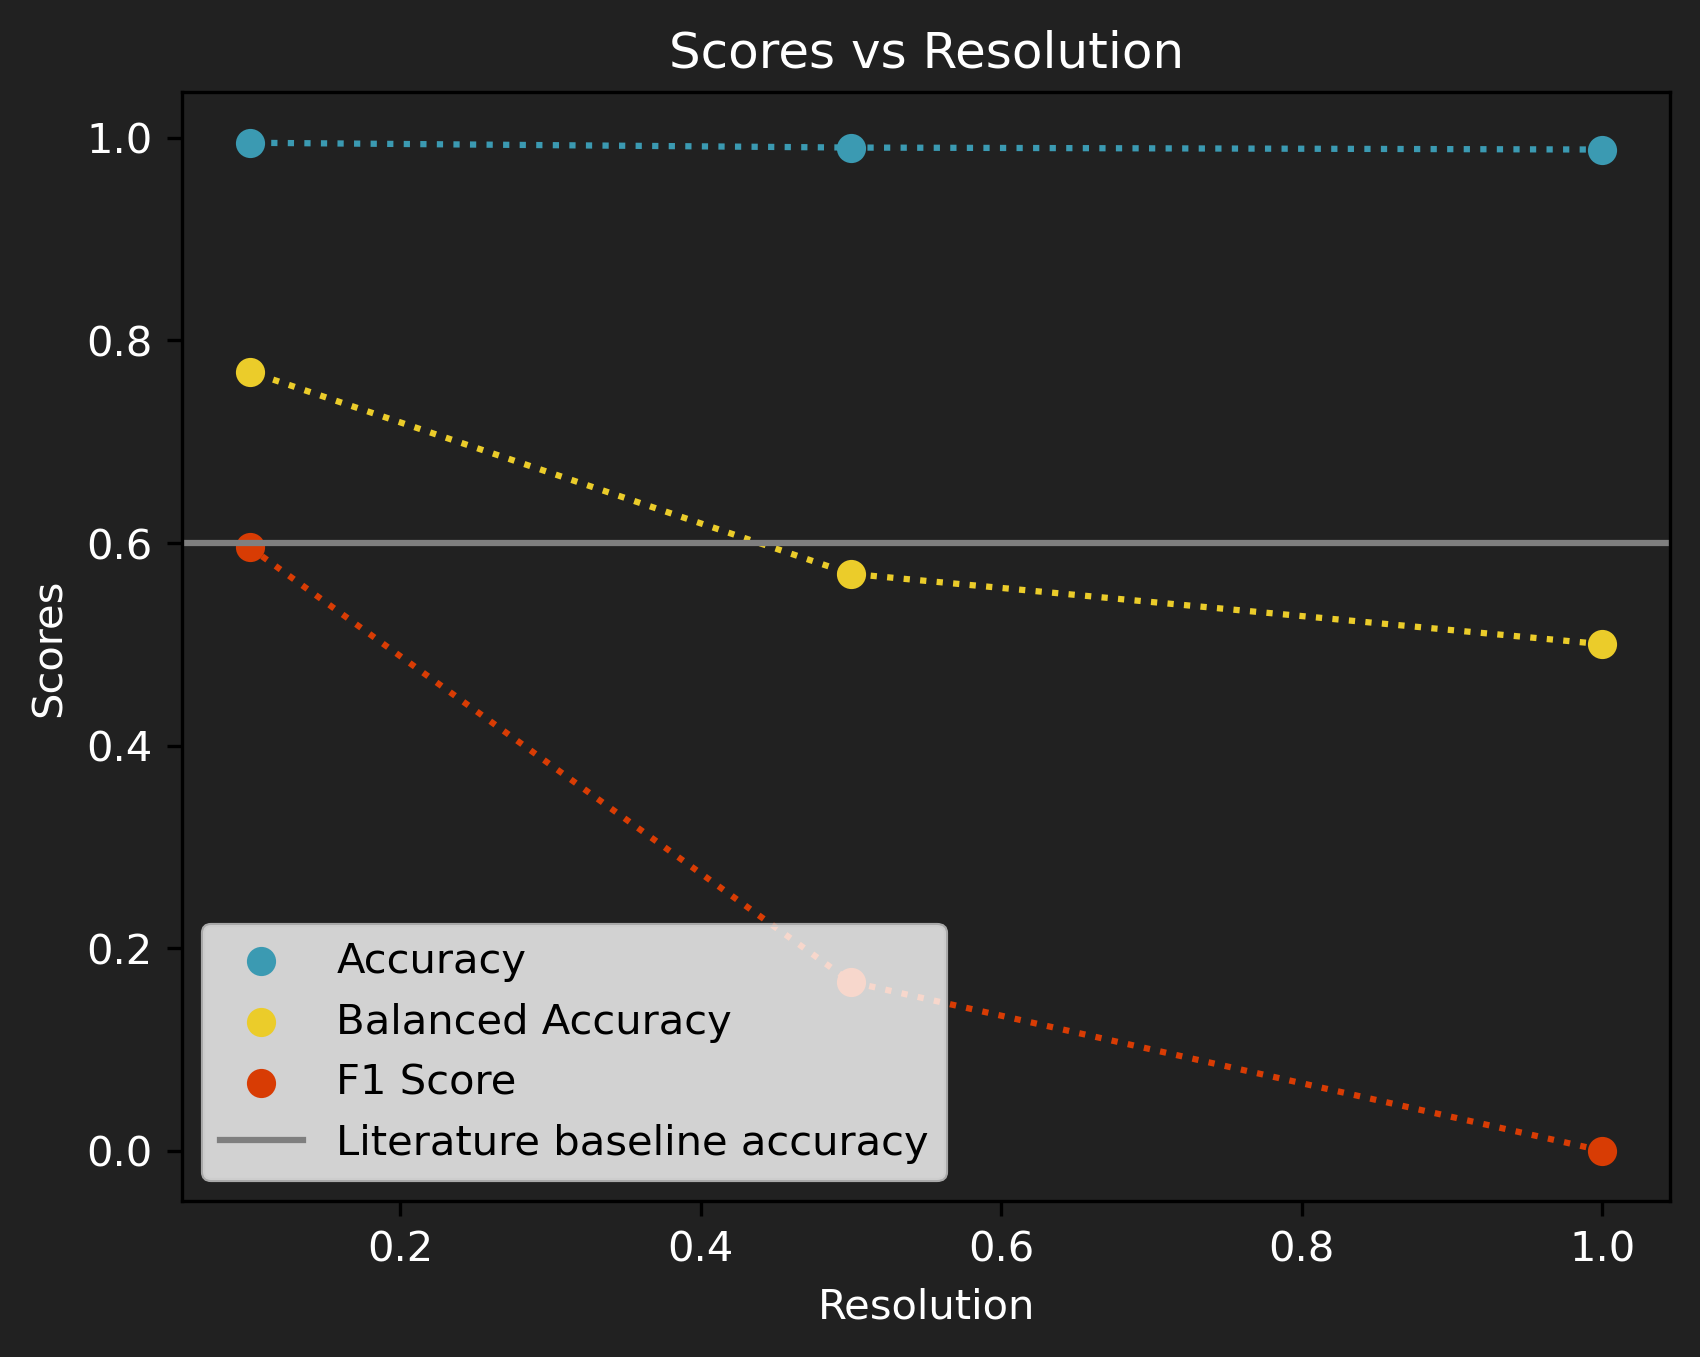

In [36]:
resolutions = [1, 0.5, 0.25, 0.1, 0.01]
man_accuracy_scores = [0.98828125, 0.990234375, 0.98876953125, 0.9949609375]
man_balanced_accuracy_scores = [0.5, 0.5694620030903217, 0.5537305421363392, 0.7689423737055896]
man_f1_scores = [0.0, 0.16666666666666666, 0.17857142857142855, 0.5956112852664577]



# Colors
colors = ["#3B9AB2", "#EBCC2A", "#d83c04"]
scores = [man_accuracy_scores, man_balanced_accuracy_scores, man_f1_scores]
score_names = ['Accuracy', 'Balanced Accuracy', 'F1 Score']


# Plotting
fig, ax = plt.subplots(dpi=300)

for idx, score in enumerate(scores):
    ax.scatter(resolutions[:len(score)], score, label=score_names[idx], color=colors[idx])
    ax.plot(resolutions[:len(score)], score, linestyle=':', color=colors[idx])

ax.axhline(0.6,c="#7F7F7F", label="Literature baseline accuracy")
# Adding labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Scores')
ax.set_title('Scores vs Resolution')

customize_plot_colors(fig, ax)

# Adding legend
ax.legend(loc="lower left")

In [ ]:
# def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, gt="unep_coral_presence"):
    
#     if useTrainCV:
        
#         cluster = dask.distributed.LocalCluster()
#         client = dask.distributed.Client(cluster)
    

#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[gt].values)
#         print("cv fitting...")
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
# #     alg.fit(dtrain[predictors], dtrain['unep_coral_presence'],eval_metric='auc')
#     print("fitting algo...")
#     alg.fit(dtrain[predictors], dtrain['unep_coral_presence'],eval_metric='auc')

    
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[gt].values, dtrain_predictions))
#     print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[gt], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    
#     return alg
    

# predictors = [s for s in X_df.columns if s.startswith("thetao") and not (s.endswith("min") or s.endswith("max"))] + [
#     "so_overall_mean", "so_september_min", "so_may_max"] + ["vo_overall_mean", "vo_september_min", "vo_may_max"] + ["uo_overall_mean", "uo_september_min", "uo_may_max"] + ["elevation", "seafloor_slope"]
# # predictors

# dtrain = pd.concat([X_df, y_df], axis=1)[::2]


# xgb1 = xgb.XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective='binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=42)

# modelfit(xgb1, dtrain, predictors, cv_folds=2, early_stopping_rounds=5)

/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41897 instead
  warnings.warn(
/home/jovyan/lustre_scratch/conda-envs/coralshift/lib/python3.10/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


cv fitting...
fitting algo...


In [ ]:
# f,ax=plt.subplots(ncols=len(Xs), subplot_kw={"projection": ccrs.PlateCarree()})
# # das = []
# for i, df in enumerate(Xs):
#     ds = spatial_data.process_xa_d(df.to_xarray())
#     spatial_plots.plot_spatial(ds["elevation"], fax=(f,ax[i]))
    

In [ ]:
# spatial_plots.plot_spatial(pd.concat(Xs, axis=0).to_xarray()["elevation"])

In [ ]:
test_ds = spatial_data.process_xa_d(ds_to_ml_ready(subset_list[1])[0].to_xarray())

In [ ]:
# rf_ds = xa.open_dataset("data/temp_rf_lats_-32-0_lons_130-170_ds.nc", chunks="auto")
# rf_ds

trans_ds = xa.open_dataset("data/temp_trans_lats_-32-0_lons_130-170_ds.nc", chunks="auto")
trans_preds = ["uo","vo","so","thetao","tos","elevation","seafloor_slope"]
gt = "unep_coral_presence"
# split_dataset_and_save(ds_fp="data/temp_trans_lats_-32-0_lons_130-170_ds.nc", divisor=8, output_dir_name="trans", select_vars=trans_preds+[gt])


In [ ]:
# spatial_plots.plot_spatial(trans_ds["so"].isel(time=100)) # showing nans, poorly saved trans file

In [ ]:
# trans_subset1 = xa.open_dataset("data/64_split_datasets/temp_trans__lats_-12--8_lons_130-135.nc").compute()
# trans_subset2 = xa.open_dataset("data/64_split_datasets/temp_trans__lats_-20--16_lons_150-155.nc").compute()
# trans_subset_list = [trans_subset1, trans_subset2]

In [ ]:
# buffered_evs = xa.open_dataset("data/env_vars/cmip6/BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc", chunks="auto")
# get_data.get_data("transformer", 0.01, 0.01) # this falls over on concatenation


In [ ]:
# min_depth, max_depth = -100, 0

# f,ax = plt.subplots(ncols=len(trans_subset_list), nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[4,4])
# for s, trans_subset in enumerate(trans_subset_list):
#     mask = (trans_subset["elevation"] > min_depth) & (trans_subset["elevation"] < max_depth)
#     spatial_plots.plot_spatial(trans_subset["unep_coral_presence"], fax=(f,ax[s,0]), title="", cbar=False)
#     spatial_plots.plot_spatial(mask, fax=(f,ax[s,1]), title="", cbar=False)


In [ ]:
# visualising coral masks
subset1 = xa.open_dataset("data/64_split_datasets/temp_rf__lats_-12--8_lons_130-135.nc").compute()
subset2 = xa.open_dataset("data/64_split_datasets/temp_rf__lats_-20--16_lons_150-155.nc").compute()

subset_list = [subset1, subset2]

In [ ]:
min_depth, max_depth = -50, 0

f,ax = plt.subplots(ncols=len(subset_list), nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[4,4])
for s, subset in enumerate(subset_list):
    mask = (subset["elevation"] > min_depth) & (subset["elevation"] < max_depth)
    spatial_plots.plot_spatial(subset["unep_coral_presence"], fax=(f,ax[s,0]), title="", cbar=False)
    spatial_plots.plot_spatial(mask, fax=(f,ax[s,1]), title="", cbar=False)


In [ ]:
# np.shape(y)
sum(y)

In [ ]:
# class imbalance
# plt.hist(y);

In [ ]:
(len(y)-sum(y))/sum(y)

In [ ]:
# from numpy import mean
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from xgboost import XGBClassifier
# # generate dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
#  n_clusters_per_class=2, weights=[0.5], flip_y=0, random_state=7)

# y[:10]

In [ ]:
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
clf = dask_RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='roc_auc')

clf.fit(X_train, y_train)

In [ ]:
clf.cv_results_
# clf.get_xgb_params()

In [ ]:
# import sklearn.metrics as sklmetrics
# sklmetrics.get_scorer_names()

X_train, y_train = train_Xs.to_numpy(), cont_to_class(train_ys.to_numpy(), threshold=threshold)


# define model
model = xgb.XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
# # dy_train = dask.array.from_array(y_train)
# # dy_train.repartition(dX_train.npartitions)
# # dy_train.npartitions

# (len(dy_train)-sum(dy_train))/sum(dy_train)

dy_train_rechunked = dy_train

In [ ]:
threshold=0.25
# model_type = "regression"
split = "manual"
model_type = "classification"

# X_train, y_train = ds_to_ml_ready(train_dss)
# X_test, y_test = ds_to_ml_ready(test_dss)
# X_train, y_train = train_Xs.to_numpy(), train_ys.to_numpy()
# X_test, y_test = test_Xs.to_numpy()[:10000], test_ys.to_numpy()[:10000]

n_samples = 100000

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
elif split == "manual":
    X_train, y_train = X_df[:n_samples], y_df[:n_samples]
    X_test, y_test = X_df[n_samples:n_samples+n_samples], y_df[n_samples:n_samples+n_samples]

# Create the XGBoost DMatrices
dX_train = dask.array.from_array(X_train.to_numpy())
dy_train = dask.array.from_array(y_train.to_numpy()).rechunk(dX_train.chunksize[0])

dX_test = dask.array.from_array(X_test.to_numpy())
dy_test = dask.array.from_array(y_test.to_numpy()).rechunk(dX_test.chunksize[0])


# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)

if model_type == "classification":
    y_train = cont_to_class(y_train, threshold=threshold)
    y_test = cont_to_class(y_test, threshold=threshold)
    
    model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))
    
elif model_type == "regression":
    model = xgb.XGBRegressor(
        n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train)
    )


dtrain = xgb.dask.DaskDMatrix(client, dX_train, dy_train)
dtest = xgb.dask.DaskDMatrix(client, dX_test,  dy_test)

param_dict = {
    # 'n_estimators': 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
}

# train the model
output = xgb.dask.train(
    client, param_dict, dtrain, num_boost_round=1000, evals=[(dtrain, "train")]
)

In [ ]:
# # https://examples.dask.org/machine-learning/hyperparam-opt.html

# problem with partitions

# # local dask cluster
# cluster = LocalCluster(n_workers=4)
# client = Client(cluster)


# model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))

# params = {
#     # 'n_estimators': 100,
#     "max_depth": [0,1,2,3,5],
#     "learning_rate": [0.1,0.2],
#     "subsample": [0.7,0.8],
#     "colsample_bytree": [0.5, 0.8],
#     "objective": ["reg:squarederror"],
#     "eval_metric": ["rmse"],
# }

# # Create the RandomizedSearchCV object
# search = HyperbandSearchCV(
#     model,
#     params,
#     max_iter=10,
#     patience=True,
#     verbose=1
# )
# # Perform random search on the parameters
# search.fit(dX_train, dy_train, classes=[0, 1])


# # Get the best parameters from the search
# best_params = search.best_estimator__
# print("Best Parameters:", best_params)

In [ ]:
# make predictions
y_test_pred = xgb.dask.predict(client, output, dtest).compute()
y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test

In [ ]:
y_train_pred

In [ ]:
plt.hist(y_train)

In [ ]:
# make predictions
y_test_pred = xgb.dask.predict(client, output, dtest).compute()
y_train_pred = xgb.dask.predict(client, output, dtrain).compute() # overfitting test

# plt.scatter(y_train,y_train_pred, alpha=0.1) #overfit
# plt.scatter(y_test,y_test_pred, alpha=0.1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, cont_to_class(y_test_pred, 0.5), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["absence", "presence"])

disp.plot()

In [ ]:
sklmetrics.f1_score(y_test, cont_to_class(y_test_pred, 0.5))

In [ ]:
gt = "unep_coral_presence"
exclude_list = []
train_val_test_frac = [0.8,0,0.2]
inf_type = "classification"
threshold = 0.5
depth_mask_lims = [-50, 0]

cluster = LocalCluster(n_workers=4)
client = Client(cluster)
# client
    

In [ ]:
df_dask = subset.to_dask_dataframe()


In [ ]:
# df_dask = ds.to_dask_dataframe()
df_dask = client.persist(df_dask)

df_nonans = df_dask.fillna(0)
# apply shallow water mask
df_shallow = df_filled[(df_nonans["elevation"] < max(depth_mask_lims)) & (df_nonans["elevation"] > min(depth_mask_lims))]

In [ ]:
# df_shallow.latitude.values.compute()[:3]

In [ ]:
# scaler = dMinMaxScaler()
# df_scaled = scaler.fit_transform(df_shallow)


In [ ]:


# subsets = split_dataset_and_save(ds_fp="data/temp_rf_lats_-32-0_lons_130-170_ds.nc", divisor=divisor)

In [ ]:
subset

In [ ]:
# # start_lat_ind, start_lon_ind = 1600, 1700

# # subset = rf_ds.isel(latitude=slice(start_lat_ind,start_lat_ind+num_lats), longitude=slice(start_lon_ind,start_lon_ind+num_lons))
# # spatial_plots.plot_spatial(subset["unep_coral_presence"])

# start_lat_ind, start_lon_ind = 1200, 1700

# subset = rf_ds.isel(latitude=slice(start_lat_ind,start_lat_ind+num_lats), longitude=slice(start_lon_ind,start_lon_ind+num_lons))
# spatial_plots.plot_spatial(subset["unep_coral_presence"])

In [ ]:
import matplotlib.pyplot as plt
plt.hist(subset["elevation"].values.flatten(), bins=20);

In [ ]:
from dask_ml.preprocessing import MinMaxScaler as dMinMaxScaler

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)


def ds_to_ml_ready(ds, gt:str="unep_coral_presence", exclude_list: list[str]=[], train_val_test_frac=[0.8,0,0.2], inf_type: str="classification", threshold=0.5, depth_mask_lims = [-50, 0], client=None):
    subset_df = subset.to_dask_dataframe()
    exclude_list += ["crs", "depth", "spatial_ref"]
    predictors = [pred
    for pred in subset_df.columns
    if pred != gt and pred not in exclude_list
]
    
    if not client:
        # local dask cluster
        cluster = LocalCluster(n_workers=4)
        client = Client(cluster)
        client

    df_dask = ds.to_dask_dataframe()
    df_dask = client.persist(df_dask)

    # apply shallow water mask
    df_shallow = df_filled[(df_filled["elevation"] < max(depth_mask_lims)) & (df_filled["elevation"] > min(depth_mask_lims))]
    
    scaler = dMinMaxScaler()
    df_scaled = scaler.fit_transform(df_shallow)
    df_scaled = df_scaled.fillna(0)

    
    X = df_scaled[predictors]
    y = df_scaled[gt]
    
#     if inf_type == "classification":
#         y.loc[y >= threshold] = 1
#         y.loc[y < threshold] = 0

    return X, y#, df_filled

X, y = ds_to_ml_ready(
    subset,
#     subset.isel(latitude=slice(0, 10), longitude=slice(0, 10)),
     client = client
)
    


In [ ]:
len(X)

In [ ]:
subset = xa.open_dataset("data/64_split_datasets/temp_rf_lats_-32-0_lons_130-170_ds_lats_-12--8_lons_130-135.nc", chunks="auto")
subset_df = subset[["elevation", "seafloor_slope", "unep_coral_presence"]].to_dask_dataframe()

In [ ]:
gt = "unep_coral_presence"
exclude_list = ["crs", "depth", "spatial_ref"]
depth_mask_lims = [-50, 0]

predictors = [pred for pred in subset_df.columns
    if pred != gt and pred not in exclude_list
]

In [ ]:
df_filled = subset_df.fillna(0)
df_shallow = df_filled[(df_filled["elevation"] < max(depth_mask_lims)) & (df_filled["elevation"] > min(depth_mask_lims))]

In [ ]:
df_part = df_shallow.repartition(npartitions)

In [ ]:
# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

df_subset = subset.to_dask_dataframe()

df_subset = client.persist(df_subset)

In [ ]:
from dask_ml.preprocessing import MinMaxScaler as dMinMaxScaler

scaler = dMinMaxScaler()

scaler.fit_transform(df_subset).head()

In [ ]:
df_scaled = dask.dataframe(scaler.fit_transform(df_part), columns=df_part.columns)

In [ ]:
# # X_train_scaled_df, X_test_scaled_df = preprocess_data(common_df, label_column=gt)
# (
#     (X_train, y_train),
#     (_, _),
#     (X_test, y_test),
# ), dfs_list = functions_creche.process_df_for_rfr(
#     common_df, predictors, gt, train_val_test_frac=train_val_test_frac
# )

In [ ]:
# common_df.isnull().any(axis=1).sum() / len(common_df)

In [ ]:
plt.hist(df_scaled["unep_coral_presence"].values);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sum(y_test)

In [ ]:
import xgboost as xgb

from dask.distributed import Client, LocalCluster
import dask

# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client


model = xgb.XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score, mean_squared_error

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),eval_metric="auc",early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print(f"SCORE: {accuracy}")
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()
# takes a while to run
# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


In [ ]:
trials = Trials()
# takes a while to run
# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 100,
#                         trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
X.head(10)

In [ ]:
best_hyperparams = {'colsample_bytree': 0.950546832705698, 'gamma': 1.2728166785185486, 'max_depth': 12.0, 'min_child_weight': 9.0, 'reg_alpha': 49.0, 'reg_lambda': 0.9628698105666551}
# set necessary values to int
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])
best_hyperparams["min_child_weight"] = int(best_hyperparams["min_child_weight"])

xgb_clf = xgb.XGBClassifier(**best_hyperparams, eval_metric="auc")

xgb_clf.fit(X.iloc[:10],y.iloc[:10])

In [ ]:
# plt.scatter(y_test, xgb_clf.predict(X_test))
# mean_squared_error(y_test, xgb_clf.predict(X_test))
xgb_clf.predict_proba(X_test)

In [ ]:
print('Mean ROC AUC: %.5f' % np.mean(scores))

In [ ]:
sum(y_train)/(len(y_train)-sum(y_train))

In [ ]:
from coralshift.plotting import spatial_plots
spatial_plots.plot_spatial(subset["elevation"])

In [ ]:
gt = "unep_coral_presence"
exclude_list = []
exclude_list += ["crs", "depth", "spatial_ref"]
predictors = [
    pred
    for pred in common_df.columns
    if pred != gt and pred not in exclude_list
        ]
# common_df

In [ ]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(common_df[predictors], common_df[gt], shuffle=True)

In [ ]:
y_train.head()

In [ ]:
from dask_ml.wrappers import Incremental
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
inc = Incremental(rfr, scoring="accuracy")


In [ ]:
# inc.fit(X_train, y_train)

In [ ]:
X_array = X.to_dask_array(lengths=True)
# dtrain = xgb.dask.DaskDMatrix(client, X.to_dask_array(), y.to_dask_array())


In [ ]:
X_array[:10]

In [ ]:
from dask.distributed import Client, LocalCluster
import dask
import xgboost as xgb

from sklearn.metrics import mean_squared_error
import dask_ml.model_selection as dcv
from scipy.stats import expon
from sklearn import svm, datasets


# local dask cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

# TODO: add regressor option
model = xgb.XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)


# # Create the XGBoost DMatrices
# dtrain = xgb.dask.DaskDMatrix(
#     client, dask.array.from_array(X_train), dask.array.from_array(y_train)
# )
# dtest = xgb.dask.DaskDMatrix(
#     client, dask.array.from_array(X_test), dask.array.from_array(y_test)
# )

# Create the XGBoost DMatrices
dtrain = xgb.dask.DaskDMatrix(client, X.to_dask_array(), y.to_dask_array())
# dtest = xgb.dask.DaskDMatrix(
#     client, dask.array.from_dataframe(X_test), dask.array.from_dataframe(y_test)
# )

model_type = "brt"
model, data_type = baselines.initialise_model(model_type)
search_grid = baselines.ModelInitializer().get_search_grid(model_type)

param_dict = {
    # 'n_estimators': 100,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
}

# train the model
output = xgb.dask.train(
    client, param_dict, dtrain, num_boost_round=100, evals=[(dtrain, "train")]
)

# make predictions
# y_pred = xgb.dask.predict(client, output, dtest)
# y_pred = xgb.dask.predict(client, output, dtrain) # overfitting test


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(
    df: pd.DataFrame, y: np.ndarray, y_pred, figsize: tuple = [4, 4]
) -> None:
    """
    Evaluate model (visually and mse) on a given dataset, returning an xarray with predictions and ground truth.

    Args:
        model (sklearn model): trained model
        df (pd.DataFrame): dataframe with ground truth
        X (np.ndarray): input data
        y (np.ndarray): ground truth
        figsize (tuple, optional): figure size. Defaults to [4,4].

    Returns:
        pred_xa (xa.Dataset): xarray dataset with ground truth and predictions
    """
    # y_pred = model.predict(X)
    pred_df = functions_creche.reform_df(df, y_pred)
    mse = mean_squared_error(
        pred_df["unep_coral_presence"], pred_df["prediction"]
    )

    f, ax = plt.subplots(figsize=figsize)
    ax.scatter(y, y_pred)
    # y=x for comparison
    ax.axline((0, 0), slope=1, c="k")
    ax.axis("equal")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Prediction")
    ax.set_xlim([0, 1])

    plt.suptitle(f"MSE: {mse:.04f}")


In [ ]:
y_pred

In [ ]:
evaluate_model(dfs_list[2], y_test, y_pred)

In [ ]:


mean_squared_error(y_test, y_pred)



rfr = dcv.RandomizedSearchCV(model, search_grid, n_iter=50, cv=3)
rfr.fit(X_train, y_train)

baselines.evaluate_model(rfr, dfs_list[0], X_train, y_train)

In [ ]:
### USER INPUTS ###
resolution_lat, resolution_lon = 0.01, 0.01
lats = [-34, 0]
lons = [130, 170]

train_val_test_frac = [0.7, 0.15, 0.15]
model_type = "rf"

gt = "unep_coral_presence"
exclude_list = []  # variables to exclude in prediction


In [ ]:
### DATA ###
# buffered cmip6 xa.Dataset
cmip6_fp = (
    Path(config.cmip6_data_folder)
    / "BCC-CSM2-HR/r1i1p1f1/uo_so_vo_thetao_tos_buffered.nc"
)
cmip6_xa = xa.open_dataset(cmip6_fp)

# gebco bathymetry fp
gebco_fp = (
    Path(config.bathymetry_folder) / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0.nc"
)
gebco_xa = xa.open_dataset(gebco_fp)

# gebco slopes fp
gebco_slopes_fp = (
    Path(config.bathymetry_folder)
    / "gebco/gebco_2023_n0.0_s-40.0_w130.0_e170.0_slopes.nc"
)
gebco_slopes_xa = xa.open_dataset(gebco_slopes_fp)

# unep_wcmc shp fp
unep_fp = Path(config.gt_folder) / "unep_wcmc/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
unep_gdf = gpd.read_file(unep_fp)

# generate gt raster
unep_raster = functions_creche.rasterize_geodf(
    unep_gdf, resolution_lat=resolution_lat, resolution_lon=resolution_lon
)
# generate gt xarray
unep_xa = functions_creche.raster_to_xarray(
    unep_raster,
    x_y_limits=functions_creche.lat_lon_vals_from_geo_df(unep_gdf)[:4],
    resolution_lat=resolution_lat,
    resolution_lon=resolution_lon,
    name="unep_coral_presence",
)

In [ ]:
### PREPROCESSING ###

# derive
if model_type == "rf":
    # compute stats df
    cmip6_xa = functions_creche.calculate_statistics(cmip6_xa)

# spatially align datasets into a single xarray dataset
input_dss = [
    spatial_data.process_xa_d(xa_d)
    for xa_d in [cmip6_xa, gebco_xa, gebco_slopes_xa, unep_xa]
]
common_dataset = functions_creche.spatially_combine_xa_d_list(
    input_dss, lats, lons, resolution_lat, resolution_lon
)


In [ ]:
common_dataset

In [ ]:
if model_type == "rf":
    train_val_test_frac = [0.8, 0, 0.2]
    common_df = common_dataset.to_dask_dataframe()

In [ ]:
common_df

In [ ]:

    exclude_list += ["crs", "depth", "spatial_ref"]
    predictors = [
        pred for pred in common_df.columns if pred != gt and pred not in exclude_list
    ]

    (
        (X_train, y_train),
        (_, _),
        (X_test, y_test),
    ), dfs_list = functions_creche.process_df_for_rfr(
        common_df, predictors, gt, train_val_test_frac=train_val_test_frac
    )


In [ ]:
#     print("fitting RandomizedSearchCV...")
#     # train_random_model
#     random_model = baselines.train_tune(
#         X_train,
#         y_train,
#         "rf_reg",
#         n_iter=2,
#         cv=2,
#         name="first_random",
#         search_type="random",
#         n_jobs=-1,
#         verbose=0,
#     )

#     print(random_model.best_estimator_)

In [ ]:
# baselines.evaluate_model(random_model, dfs_list[0], X_train, y_train)

In [ ]:
# from sklearn.externals.joblib import parallel_backend

# search = RandomizedSearchCV(model, search_grid, cv=10, n_iter=1000, verbose=0)

# with parallel_backend('dask', scheduler_host='your_scheduler_host:your_port'):
#         search.fit(digits.data, digits.target)

In [ ]:
# # grid search
# best_params_dict = random_model.best_params_

# grid_model = baselines.train_tune(
#     X_train, y_train, "rf_reg", name="first_grid", search_type="grid", n_jobs=-1, verbose=0, best_params_dict=best_params_dict)